# Over-sampling using LMNN

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
sns.set()

import numpy as np
import itertools

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Save a nice dark grey as a variable
almost_black = '#262626'

Generate some data with dimension reduction to observed something.

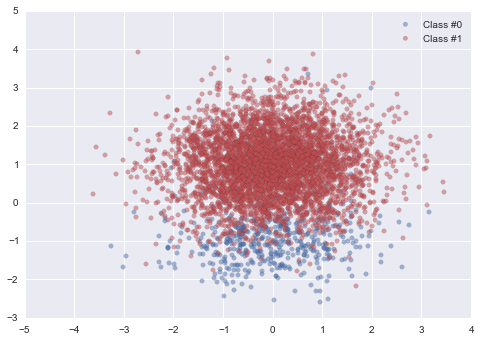

In [57]:
# Generate some data
x, y = make_classification(n_features=2, n_redundant=0, n_informative=1, class_sep=1.,
                           n_clusters_per_class=1, n_samples=5000, weights=[0.1, 0.9],
                           random_state=9)

# Instanciate a PCA object for the sake of easy visualisation
# pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
# x_vis = pca.fit_transform(x)

# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x[y==0, 0], x[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x[y==1, 0], x[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

Compute the LMNN for each sample of the minority class

In [62]:
from collections import Counter

# Compute the classes representation
stat_class = Counter(y)
# Find the minority class key
label_min_class = min(stat_class, key=stat_class.get)
label_maj_class = max(stat_class, key=stat_class.get)
# Save the sample index of this class
idx_min_class = np.ravel(np.nonzero(y == label_min_class))
idx_maj_class = np.ravel(np.nonzero(y == label_maj_class))

from sklearn.neighbors import NearestNeighbors

neighbours_required = 7

# Create an object NN only for the minority class
min_class_NN = NearestNeighbors(n_neighbors=neighbours_required)#, n_jobs=-1)
min_class_NN.fit(x[idx_min_class, :], y[idx_min_class])

# Create an object NN only for the majority class
max_class_NN = NearestNeighbors(n_neighbors=neighbours_required)#, n_jobs=-1)
max_class_NN.fit(x[idx_maj_class, :], y[idx_maj_class])

# Create an object NN for the whole dataset
data_NN = NearestNeighbors(n_neighbors=3)#, n_jobs=-1)
data_NN.fit(x, y)

# Compute all the distance of the k-NN on the minority class on the original data for the point of the minority class
dist_min, ind_min = min_class_NN.kneighbors(x[idx_min_class, :])
# Compute all the distance of the k-NN on the majority class on the original data for the point of the minority class
dist_max, ind_max = max_class_NN.kneighbors(x[idx_min_class, :])
# Find the largest distance for the both above distances
dist_min = np.max(dist_min, axis=1)
dist_max = np.max(dist_max, axis=1)

# Select the max_dist between dist_min and dist_max to ensure a minimum of neighbours
#max_dist = dist_max.copy()
max_dist = dist_min.copy()
#max_dist[np.nonzero(dist_min < dist_max)] = dist_max[np.nonzero(dist_min < dist_max)]
#max_dist[np.nonzero(dist_min > dist_max)] = dist_min[np.nonzero(dist_min > dist_max)]

# Now find the samples to consider with the distance extracted using only the minority class
# We need to loop since that the distance is changing
s_considers = []
for s, d in zip(x[idx_min_class], max_dist):
    dist, ind = data_NN.radius_neighbors(X=np.atleast_2d(s), radius=d)
    s_considers.append(ind)
    
from metric_learn import LMNN

cov_mat = []
idx_cons = []
for s in s_considers:
    # Extract the interesting data
    x_s = x[s[0], :]
    y_s = y[s[0]]
        
    # Check if there is any imposter
    stat = Counter(y_s)
    #print stat
    
    if (len(stat) > 1):
        if (stat[label_min_class] < stat[label_maj_class]):
            if ((stat[label_maj_class] / stat[label_min_class]) < 10 ):
                # Fit the LMNN for these data
                s_lmnn = LMNN(k=stat[label_min_class])
                s_lmnn.fit(x_s, y_s)
                # Store the covariance matrix
                cov_mat.append(np.dot(s_lmnn.L.T, s_lmnn.L))
                idx_cons.append(True)
            else:
                cov_mat.append(np.cov(x_s.T))
                idx_cons.append(True)
        else:
            cov_mat.append(np.cov(x_s.T))
            idx_cons.append(False)
    else:
        cov_mat.append(np.cov(x_s.T))
        idx_cons.append(False)

Function to plot a covariance with some sigma on the plot

In [4]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    ellip.set_alpha(.1)
    return ellip


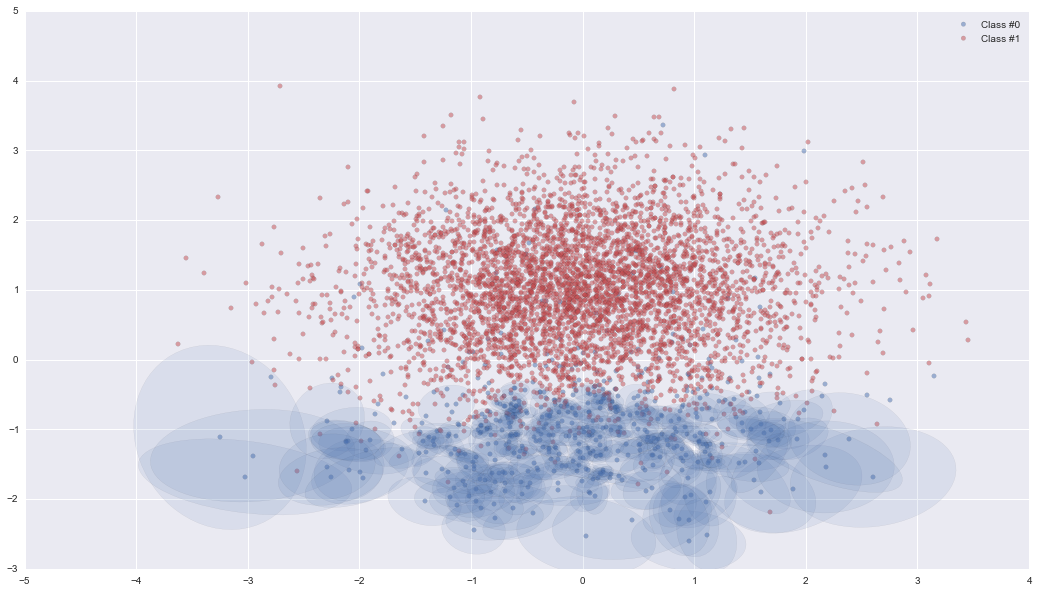

In [63]:
# Plot the data
plt.figure(figsize=(18,10))
plt.scatter(x[y==0, 0], x[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x[y==1, 0], x[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

# For each data, let's plot some elippse
for cm, s, cs in zip(cov_mat, x[idx_min_class], idx_cons):
    if (cs == False):
        plot_cov_ellipse(cm, s, nstd=2.25)
    
plt.legend()
plt.show()

In [17]:
print np.sum(np.sum(np.cov(x_s.T)))

0.00766382879906
